# Analysis

I Have a few questions going into this. 
1. Does favorite submission really exist?
2. If favorite submission exists, does it have an impact on success rate?
3. What is the most "high percentage" submission in my sample?

In [596]:
import numpy as np
import pandas as pd
import re
import sqlite3
import time
from pytictoc import TicToc
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
import statsmodels.formula.api as smf
import scikit_posthocs as sp



In [436]:
# Read in athlete info
con = sqlite3.connect('bjj_network.db')
cur = con.cursor()
Athlete_Info = pd.read_sql_query('''SELECT * FROM Athlete_List''',con)
All_Matches = pd.read_sql_query('''SELECT * FROM Athlete_Matches''',con)
# Create Short Athlete_ID column
short_athlete_ID=pd.DataFrame(columns=['Short_Athlete_ID'],index=range(0,len(Athlete_Info['Athlete_ID'])))
for id in enumerate(Athlete_Info['Athlete_ID']):
    # print(id[0])
    short_athlete_ID.iloc[id[0],0] = id[1].split('-')[0]
Athlete_Info = Athlete_Info.join(short_athlete_ID)
Athlete_Info = Athlete_Info.drop(['level_0'],axis=1)
Athlete_Info = Athlete_Info.drop(['index'],axis=1)

Athlete_Info.head()


,Athlete_Name,Athlete_ID,Record,Birthdate,Short_Athlete_ID
0,"Aaron ""Tex"" Johnson",/people/6600946-aaron-tex-johnson,87-70-1,None,/people/6600946
1,Adam Wardzinski,/people/5950131-adam-wardzinski,180-52-2,None,/people/5950131
2,Alexssandro Sodre,/people/6749113-alexssandro-sodre,82-28-0,None,/people/6749113
3,Ana Carolina Vieira,/people/5950497-ana-carolina-vieira,47-12-0,November 19 1993,/people/5950497
4,Andre Galvao,/people/5951184-andre-galvao,165-31-2,September 29 1982,/people/5951184


In [437]:
# Get Rid of Extra Index Column
All_Matches = All_Matches.drop(['index'],axis=1)
# Create shortened versions of both athlete & Opponent ID so there are no names in the ID's
short_athlete_ID=pd.DataFrame(columns=['Short_Athlete_ID'],index=range(0,len(All_Matches['Athlete_ID'])))
for id in enumerate(All_Matches['Athlete_ID']):
    # print(id[0])
    short_athlete_ID.iloc[id[0],0] = id[1].split('-')[0]

short_opponent_ID=pd.DataFrame(columns=['Short_Opponent_ID'],index=range(0,len(All_Matches['Opponent_Link'])))
for id in enumerate(All_Matches['Opponent_Link']):
    # print(id[0])
    short_opponent_ID.iloc[id[0],0] = id[1].split('-')[0]
All_Matches = All_Matches.join(short_athlete_ID)
All_Matches = All_Matches.join(short_opponent_ID)

# Apparently some matches were recorded as an athlete fighting themselves so lets get rid of that
All_Matches = All_Matches[~All_Matches.apply(lambda x: x['Short_Athlete_ID'] == x['Short_Opponent_ID'], axis=1)]
# Drop Duplicates
All_Matches = All_Matches.drop_duplicates()
# Drop Unecessary Variables
All_Matches = All_Matches.drop(['Weight_Link'],axis=1)
All_Matches = All_Matches.drop(['Method_Link'],axis=1)
All_Matches = All_Matches.drop(['Event_Link'],axis=1)
All_Matches = All_Matches.drop(['Replay'],axis=1)
All_Matches = All_Matches.drop(['Replay_Link'], axis=1)
All_Matches = All_Matches.drop(['Date_Link'], axis=1)
All_Matches = All_Matches.drop(['W/L_Link'], axis = 1)

# Add Name based on ID

All_Matches = All_Matches.merge(Athlete_Info[['Athlete_Name','Short_Athlete_ID']],left_on = 'Short_Athlete_ID',right_on='Short_Athlete_ID',how='left')
All_Matches.rename(columns={'Athlete_Name':'athlete_name'},inplace=True)

All_Matches = All_Matches.merge(Athlete_Info[['Athlete_Name','Short_Athlete_ID']],left_on = 'Short_Opponent_ID',right_on='Short_Athlete_ID',how='left')
All_Matches.rename(columns={'Athlete_Name':'Opponent_Name'},inplace=True)

All_Matches.rename(columns={'athlete_name':'Athlete_Name'},inplace=True)
All_Matches.rename(columns={'Short_Athlete_ID_x':'Short_Athlete_ID'},inplace=True)
All_Matches = All_Matches.drop(['Short_Athlete_ID_y'],axis=1)


All_Matches.head()

,Athlete_ID,Year,Date,W/L,Method,Opponent,Opponent_Link,Weight,Event,Short_Athlete_ID,Short_Opponent_ID,Athlete_Name,Opponent_Name
0,/people/6600946-aaron-tex-johnson,2021,09/25,W,DQ,O. Sanchez,/people/6571306,Heavyweight,2021 FloGrappling WNO Championship,/people/6600946,/people/6571306,"Aaron ""Tex"" Johnson",Orlando Sanchez
1,/people/6600946-aaron-tex-johnson,2021,09/25,L,Decision,T. Spriggs,/people/5950976,Heavyweight,2021 FloGrappling WNO Championship,/people/6600946,/people/5950976,"Aaron ""Tex"" Johnson",Tim Spriggs
2,/people/6600946-aaron-tex-johnson,2021,07/09,L,Decision,G. Batista,/people/5952220,Absolute Division,Fight to Win 176,/people/6600946,/people/5952220,"Aaron ""Tex"" Johnson",Gustavo Batista
3,/people/6600946-aaron-tex-johnson,2021,06/18,W,Decision,L. Barbosa,/people/5951235,---,Fight to Win 174,/people/6600946,/people/5951235,"Aaron ""Tex"" Johnson","Lucas ""Hulk"" Barbosa"
4,/people/6600946-aaron-tex-johnson,2021,05/15,W,Other,J. Hansen,/people/6749112,Ultra Heavyweight,2021 Pan IBJJF Jiu-Jitsu No-Gi Championship,/people/6600946,/people/6749112,"Aaron ""Tex"" Johnson",John Hansen


In [438]:
# Get only wins
Wins = All_Matches[All_Matches['W/L']=='W']


In [439]:
# Get only athletes who've had 10 matches
def get_total_matches(record):
    pieces = record.split('-')
    total_matches = int(pieces[0]) + int(pieces[1]) + int(pieces[2])
    return total_matches
# First drop missing data based on record
Athlete_Info = Athlete_Info.dropna(subset=['Record'])

# Now apply
Athlete_Info['Total_Matches'] = Athlete_Info.apply(lambda row : get_total_matches(row['Record']), axis=1)


Athlete_Info_10 = Athlete_Info.loc[Athlete_Info['Total_Matches']>=10]
Wins = Wins[Wins['Short_Athlete_ID'].isin(Athlete_Info_10['Short_Athlete_ID']) & Wins['Short_Opponent_ID'].isin(Athlete_Info_10['Short_Athlete_ID'])]

In [440]:
# Drop data when we don't know the athlete or it was more than 5 years ago
Wins = Wins.dropna(subset = ['Athlete_Name'])
Wins = Wins[Wins['Year']>='2018']

In [441]:
Wins.tail()

,Athlete_ID,Year,Date,W/L,Method,Opponent,Opponent_Link,Weight,Event,Short_Athlete_ID,Short_Opponent_ID,Athlete_Name,Opponent_Name
38190,/people/6808269,2020,01/18,W,Other,A. Campos,/people/6808508,120kgs,2020 Abu Dhabi Grand Slam Abu Dhabi,/people/6808269,/people/6808508,Mansur Makhmakhanov,Andre Campos
38191,/people/6808269,2020,01/18,W,Points,A. Campos,/people/6808508,120kgs,2020 Abu Dhabi Grand Slam Abu Dhabi,/people/6808269,/people/6808508,Mansur Makhmakhanov,Andre Campos
38193,/people/6808269,2019,01/15,W,Other,B. Giorgio,/people/6808270,Absolute Division,2019 European Jiu-Jitsu IBJJF Championship,/people/6808269,/people/6808270,Mansur Makhmakhanov,Brian Giorgio
38223,/people/6801730,2019,09/14,W,Arm Triangle Choke,K. Fadlallah,/people/6801706,Absolute Division,2019 Pan IBJJF Jiu-Jitsu No-Gi Championship,/people/6801730,/people/6801706,Frederik Vosgrone,Khalil Fadlallah
38226,/people/6801730,2019,09/14,W,Other,K. Sette,/people/6801765,Absolute Division,2019 Pan IBJJF Jiu-Jitsu No-Gi Championship,/people/6801730,/people/6801765,Frederik Vosgrone,Kenji Sette


## Now that the data is loaded up, lets see what our submissions look like

In [442]:
Wins['Method'].unique()

array(['DQ', 'Other', 'Outside Heel Hook', 'Advantage', 'Armlock',
       'Straight Ankle Lock', 'Decision', 'Armbar', 'Heel Hook',
       'Knee Bar', 'Kimura', 'Inside Heel Hook', 'Split Decision',
       'Points', 'Footlock', 'Calf Slicer', 'Ezekiel Choke',
       'Bow and Arrow', 'Katagatame', 'Choke From the Back', 'Triangle',
       'Penalty', 'Choke', 'Arm Triangle Choke', 'Lapel Choke', 'Ezekiel',
       'RNC', 'OT', 'Toehold', 'Choke from Mount', 'Choke from Crucifix',
       'Ankle Lock', 'Guillotine', 'Shoulder Lock', 'Injury',
       'Reverse Triangle', 'Wrist Lock', 'Triangle Arm Bar',
       'Cachecol Choke', 'Cross Choke', 'Golden Score', 'Flying Triangle',
       'Americana', 'Omoplata', 'Baratoplata', 'Twister',
       'Mounted Triangle', 'N/A - Draw', 'Darce Choke',
       'Arm in Guillotine', 'Clover Leaf', 'Riding Time',
       'Double Collar Choke', 'Brabo Choke', 'Bread and Butter',
       'Leg Lock', 'Loop Choke', 'OT Takedown', 'Triangle Choke',
       'Estima Lo

How many in each category?

In [443]:
Wins['Count']=1
Submission_Freq = Wins.groupby(['Method'])['Count'].sum().reset_index()
# Submission_Freq.head()

In [444]:
pd.set_option('display.min_rows',40)
pd.set_option('display.max_rows',42)

In [445]:

total = Submission_Freq['Count'].sum()
Submission_Freq['Pct'] = Submission_Freq['Count']/total * 100

Submission_Freq.sort_values(by='Count',ascending=False)

,Method,Count,Pct
52,Points,2188,32.617770
49,Other,1159,17.277877
25,Decision,853,12.716160
0,Advantage,572,8.527132
17,Choke From the Back,239,3.562910
6,Armbar,214,3.190221
53,RNC,187,2.787716
60,Triangle,115,1.714371
16,Choke,108,1.610018
58,Straight Ankle Lock,87,1.296959


The above shows that the majority of matches (~71%) are finished by Points (32%), Other (17%), Decision (13%), or Advantage (9%).

Before we continue, I would assert that this is a meaningful finding. While not included in my original plan, submissions are the minority in brazilian jiu jitsu matchs. Looking soley at submissions is likely ignoring a large part of what creates success as a competitor. While I'm not sure what FloGrappling defines as "Other", this suggests that "hustling" or "being first" is a large factor in success. Being aggresive and getting a takedown in the first few seconds could give you the point advantage necessary to win, since a match being decided on points is only slightly less likely than a match ending in any submission (30% vs 33%).



## Next we'll remove all non submissions to see how they compare

In [446]:
Submission_Freq.drop(Submission_Freq[Submission_Freq['Method'] == 'Penalty'].index,inplace=True)
Submission_Freq.drop(Submission_Freq[Submission_Freq['Method'] == 'Split Decision'].index,inplace=True)
Submission_Freq.drop(Submission_Freq[Submission_Freq['Method'] == 'Decision'].index,inplace=True)
Submission_Freq.drop(Submission_Freq[Submission_Freq['Method'] == 'Points'].index,inplace=True)
Submission_Freq.drop(Submission_Freq[Submission_Freq['Method'] == 'DQ'].index,inplace=True)
Submission_Freq.drop(Submission_Freq[Submission_Freq['Method'] == 'Advantage'].index,inplace=True)
Submission_Freq.drop(Submission_Freq[Submission_Freq['Method'] == 'Other'].index,inplace=True)
Submission_Freq.drop(Submission_Freq[Submission_Freq['Method'] == 'N/A - Draw'].index,inplace=True)
Submission_Freq.drop(Submission_Freq[Submission_Freq['Method'] == 'OT'].index,inplace=True)
Submission_Freq.drop(Submission_Freq[Submission_Freq['Method'] == 'Injury'].index,inplace=True)
Submission_Freq.drop(Submission_Freq[Submission_Freq['Method'] == 'OT Takedown'].index,inplace=True)
Submission_Freq.drop(Submission_Freq[Submission_Freq['Method'] == 'Golden Score'].index,inplace=True)
Submission_Freq.drop(Submission_Freq[Submission_Freq['Method'] == 'Riding Time'].index,inplace=True)


## At this point we have decisions to make

Many of these submissions could be classified as different groups, for example a loop choke is a lapel choke and the darce choke anaconda choke, and brabo choke are all very similar and fall into the category of arm triangle choke. 

I have decided to leave all of the submissions alone for this, largely because there is an element of individual variation with all moves, but also because I don't have video evidence to reclassify the submission.

In [447]:
Submission_Freq['Method'].unique()

array(['Americana', 'Anaconda Choke', 'Ankle Lock', 'Arm Triangle Choke',
       'Arm in Guillotine', 'Armbar', 'Armlock', 'Baratoplata',
       'Baseball Bat Choke', 'Bow and Arrow', 'Brabo Choke',
       'Bread Cutter Choke', 'Bread and Butter', 'Cachecol Choke',
       'Calf Slicer', 'Choke', 'Choke From the Back',
       'Choke from Crucifix', 'Choke from Mount', 'Clover Leaf',
       'Collar Choke', 'Cross Choke', 'Darce Choke',
       'Double Collar Choke', 'Estima Lock', 'Ezekiel', 'Ezekiel Choke',
       'Flying Triangle', 'Footlock', 'Guillotine', 'Heel Hook',
       'Inside Heel Hook', 'Katagatame', 'Kimura', 'Knee Bar',
       'Lapel Choke', 'Leg Lock', 'Loop Choke', 'Mounted Triangle',
       'Neck Crank', 'Omoplata', 'Outside Heel Hook', 'RNC',
       'Reverse Triangle', 'Shoulder Lock', 'Straight Ankle Lock',
       'Toehold', 'Triangle', 'Triangle Arm Bar', 'Triangle Choke',
       'Twister', 'Wrist Lock'], dtype=object)

In [448]:
Submission_Freq['Pct'] = Submission_Freq['Count']/Submission_Freq['Count'].sum()
Submission_Freq.shape

(52, 3)

In [449]:
Submission_Freq.sort_values(by=['Count'],ascending=False)

,Method,Count,Pct
17,Choke From the Back,239,0.145289
6,Armbar,214,0.130091
53,RNC,187,0.113678
60,Triangle,115,0.069909
16,Choke,108,0.065653
58,Straight Ankle Lock,87,0.052888
36,Inside Heel Hook,69,0.041945
34,Heel Hook,66,0.040122
39,Knee Bar,61,0.037082
33,Guillotine,57,0.034650


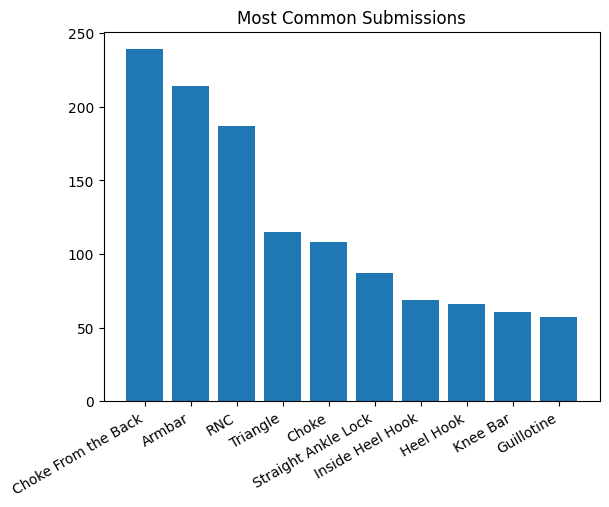

In [450]:
plt.title('Most Common Submissions')
plt.bar(Submission_Freq.sort_values(by=['Count'],ascending=False).iloc[0:10,0],Submission_Freq.sort_values(by=['Count'],ascending=False).iloc[0:10,1])
plt.xticks(rotation=30,ha='right')
plt.show()

plt.bar(Submission_Freq['Method'],Submission_Freq['Count'])

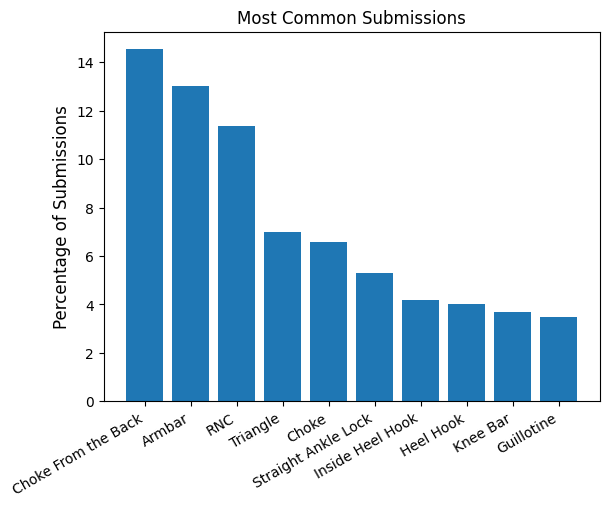

In [519]:
plt.title('Most Common Submissions')
plt.bar(Submission_Freq.sort_values(by=['Count'],ascending=False).iloc[0:10,0],Submission_Freq.sort_values(by=['Count'],ascending=False).iloc[0:10,2]*100)
plt.ylabel('Percentage of Submissions',size=12)
plt.xticks(rotation=30,ha='right')
plt.show()

From this the most common submission is Armbar, though choke from the back and Rear naked choke can likely be folded in together. 

## Get more usable features

For all of the below processes I want to start by only filtering the past 5 years of data. When getting the favorite submission I used only the 'Win" dataframe (which was already filtered), but for recent matches and recent wins I want to use the 'All_Matches' dataframe (which hasn't been filtered).

From here I made a function to get favorite submission, getting a count of all an athletes successful submissions, but removing any that aren't submissions. I nestled this in a try except since some athletes have no wins.

I then made functions to get recent wins and total number of recent matches. At this point I created a win percentage column, and saved the whole datframe to my database.


In [452]:
All_Matches = All_Matches[All_Matches['Year']>='2018']
All_Matches['Count'] = 1

In [453]:
def get_favorite_submission(athlete_name):
    Sample_Matches = Wins[Wins['Athlete_Name'] == athlete_name]
    nacondition = 'Athlete has no matches'
    try:
        Sample_Matches['Count'] = 1
        Sample_Matches = Sample_Matches.groupby(['Method'])['Count'].sum().reset_index()
        
        Sample_Matches.drop(Sample_Matches[Sample_Matches['Method'] == 'Advantage'].index,inplace=True)
        Sample_Matches.drop(Sample_Matches[Sample_Matches['Method'] == 'Penalty'].index,inplace=True)
        Sample_Matches.drop(Sample_Matches[Sample_Matches['Method'] == 'Split Decision'].index,inplace=True)
        Sample_Matches.drop(Sample_Matches[Sample_Matches['Method'] == 'Decision'].index,inplace=True)

        Sample_Matches.drop(Sample_Matches[Sample_Matches['Method'] == 'Points'].index,inplace=True)
        Sample_Matches.drop(Sample_Matches[Sample_Matches['Method'] == 'DQ'].index,inplace=True)
        Sample_Matches.drop(Sample_Matches[Sample_Matches['Method'] == 'Other'].index,inplace=True)
        Sample_Matches.drop(Sample_Matches[Sample_Matches['Method'] == 'N/A - Draw'].index,inplace=True)
        Sample_Matches.drop(Sample_Matches[Sample_Matches['Method'] == 'OT'].index,inplace=True)
        Sample_Matches.drop(Sample_Matches[Sample_Matches['Method'] == 'Injury'].index,inplace=True)
        Sample_Matches.drop(Sample_Matches[Sample_Matches['Method'] == 'OT Takedown'].index,inplace=True)
        Sample_Matches.drop(Sample_Matches[Sample_Matches['Method'] == 'Golden Score'].index,inplace=True)
        Sample_Matches.drop(Sample_Matches[Sample_Matches['Method'] == 'Riding Time'].index,inplace=True)
        Sample_Matches = Sample_Matches.set_index('Method')
        Favorite_Submission = Sample_Matches['Count'].idxmax()
        return Favorite_Submission
    except:
        pass
    


In [454]:
Athlete_Info['Favorite_Submission'] = Athlete_Info.apply(lambda row : get_favorite_submission(row['Athlete_Name']), axis=1)
Athlete_Info.head()

,Athlete_Name,Athlete_ID,Record,Birthdate,Short_Athlete_ID,Total_Matches,Favorite_Submission
0,"Aaron ""Tex"" Johnson",/people/6600946-aaron-tex-johnson,87-70-1,None,/people/6600946,158,Straight Ankle Lock
1,Adam Wardzinski,/people/5950131-adam-wardzinski,180-52-2,None,/people/5950131,234,Choke From the Back
2,Alexssandro Sodre,/people/6749113-alexssandro-sodre,82-28-0,None,/people/6749113,110,Armbar
3,Ana Carolina Vieira,/people/5950497-ana-carolina-vieira,47-12-0,November 19 1993,/people/5950497,59,Arm Triangle Choke
4,Andre Galvao,/people/5951184-andre-galvao,165-31-2,September 29 1982,/people/5951184,198,None


In [455]:
# Get win pct since 2018

athlete = 'Craig Jones'

match_total = All_Matches[All_Matches['Athlete_Name'] == athlete].groupby(['W/L'])['Count'].sum().reset_index()
wins = int(match_total[match_total['W/L'] == 'W']['Count'])
recent_matches = match_total['Count'].sum()
print('Number of Wins:',wins,'-- Number of recent matches:',recent_matches)


Number of Wins: 41 -- Number of recent matches: 53


In [456]:
def get_athlete_wins(athlete_name):
    try:
        match_total = All_Matches[All_Matches['Athlete_Name'] == athlete_name].groupby(['W/L'])['Count'].sum().reset_index()
        wins = int(match_total[match_total['W/L'] == 'W']['Count'])
        return wins
    except:
        pass


In [457]:
def get_recent_matches(athlete_name):
    try:
        match_total = All_Matches[All_Matches['Athlete_Name'] == athlete_name].groupby(['W/L'])['Count'].sum().reset_index()
        recent_matches = match_total['Count'].sum()
        return recent_matches
    except:
        pass


In [458]:
Athlete_Info['Recent_Wins'] = Athlete_Info.apply(lambda row : get_athlete_wins(row['Athlete_Name']), axis=1)
Athlete_Info['Recent_Matches'] = Athlete_Info.apply(lambda row : get_recent_matches(row['Athlete_Name']), axis=1)
Athlete_Info['Win_Pct'] = Athlete_Info['Recent_Wins']/Athlete_Info['Recent_Matches']

Athlete_Info['Recent_Wins'] = Athlete_Info['Recent_Wins'].fillna(0)
Athlete_Info['Recent_Matches'] = Athlete_Info['Recent_Matches'].fillna(0)
Athlete_Info['Win_Pct'] = Athlete_Info['Win_Pct'].fillna(0)
Athlete_Info['Recent_Wins'] = Athlete_Info['Recent_Wins'].astype('int')

Athlete_Info.head()



,Athlete_Name,Athlete_ID,Record,Birthdate,Short_Athlete_ID,Total_Matches,Favorite_Submission,Recent_Wins,Recent_Matches,Win_Pct
0,"Aaron ""Tex"" Johnson",/people/6600946-aaron-tex-johnson,87-70-1,None,/people/6600946,158,Straight Ankle Lock,58,97,0.597938
1,Adam Wardzinski,/people/5950131-adam-wardzinski,180-52-2,None,/people/5950131,234,Choke From the Back,125,160,0.781250
2,Alexssandro Sodre,/people/6749113-alexssandro-sodre,82-28-0,None,/people/6749113,110,Armbar,77,101,0.762376
3,Ana Carolina Vieira,/people/5950497-ana-carolina-vieira,47-12-0,November 19 1993,/people/5950497,59,Arm Triangle Choke,41,53,0.773585
4,Andre Galvao,/people/5951184-andre-galvao,165-31-2,September 29 1982,/people/5951184,198,None,2,5,0.400000


Save this new dataframe to the database

In [459]:
con = sqlite3.connect("bjj_network.db")

cur = con.cursor()

Athlete_Info.to_sql('Athlete_List_Detailed', con, if_exists='replace',index=False)

con.commit()

# Visualizations

Exploring time!!

In [477]:
Athlete_Info['Recent_Wins'] = Athlete_Info['Recent_Wins'].astype('int')
Athlete_Info = Athlete_Info[Athlete_Info['Recent_Wins'] > 0]
Athlete_Info['Count'] =1

In [461]:
Athlete_Info['Favorite_Submission'] = Athlete_Info['Favorite_Submission'].fillna('No Favorite')

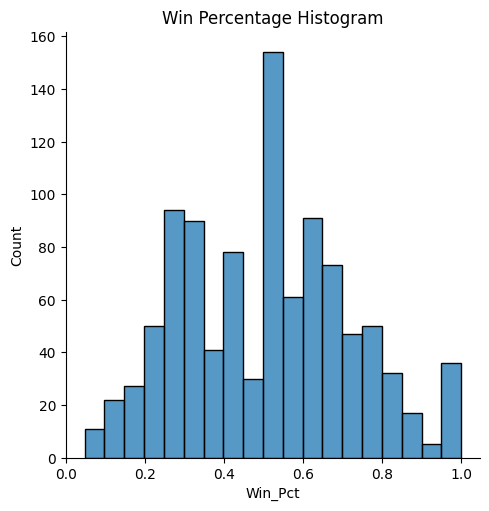

In [494]:
sns.displot(Athlete_Info, x='Win_Pct',binwidth = 0.05).set(title='Win Percentage Histogram')
plt.show()

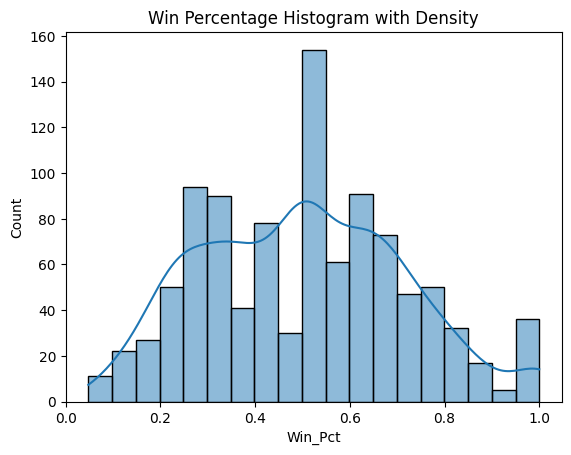

In [493]:
sns.histplot(Athlete_Info, x='Win_Pct',binwidth = 0.05, kde=True).set(title='Win Percentage Histogram with Density')
plt.show()

Normal?
Appears semi normal

Lets run a shapiro wilks test for normality.

In [485]:
stats.shapiro(Athlete_Info['Win_Pct'])

ShapiroResult(statistic=0.9813380241394043, pvalue=4.444605239406485e-10)

P value is very small so we reject the null, meaning the data isn't normal.

I'll confirm with a qq plot.

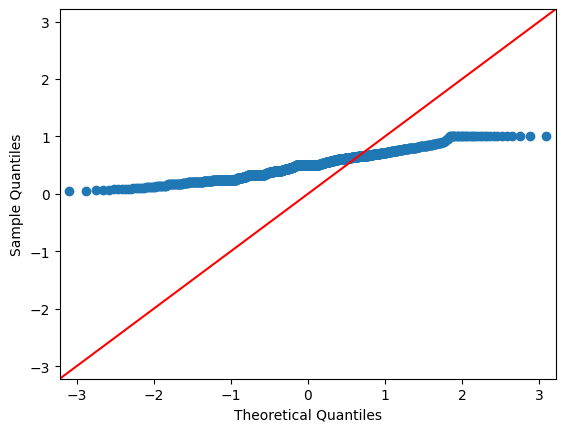

In [489]:
sm.qqplot(Athlete_Info['Win_Pct'],line='45')
plt.show()

Important to note that this is non normal, so going forward I will use non parametric tests.

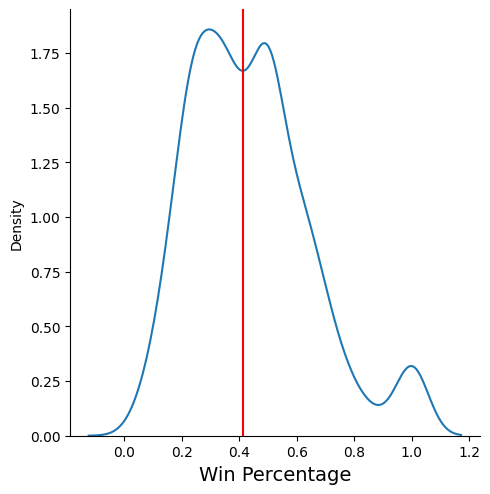

In [495]:
# No Favorite
sns.displot(Athlete_Info[Athlete_Info['Favorite_Submission'] == 'No Favorite'], x='Win_Pct', kind= 'kde')
plt.xlabel('Win Percentage',size=14)
plt.axvline(x=Athlete_Info[Athlete_Info['Favorite_Submission'] == 'No Favorite']['Win_Pct'].median(),color='red')
plt.show()

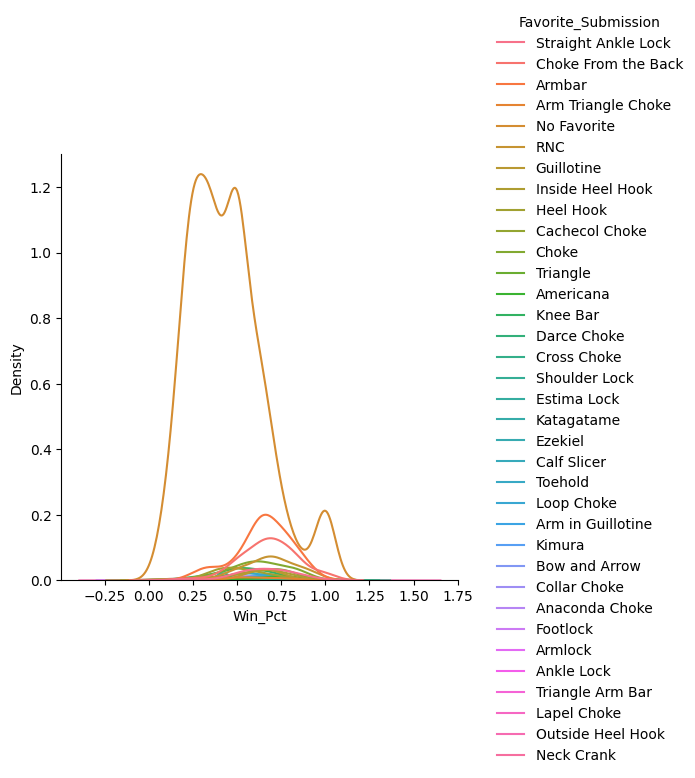

In [496]:
sns.displot(Athlete_Info, x='Win_Pct', kind= 'kde', hue = 'Favorite_Submission',warn_singular=False)
plt.show()

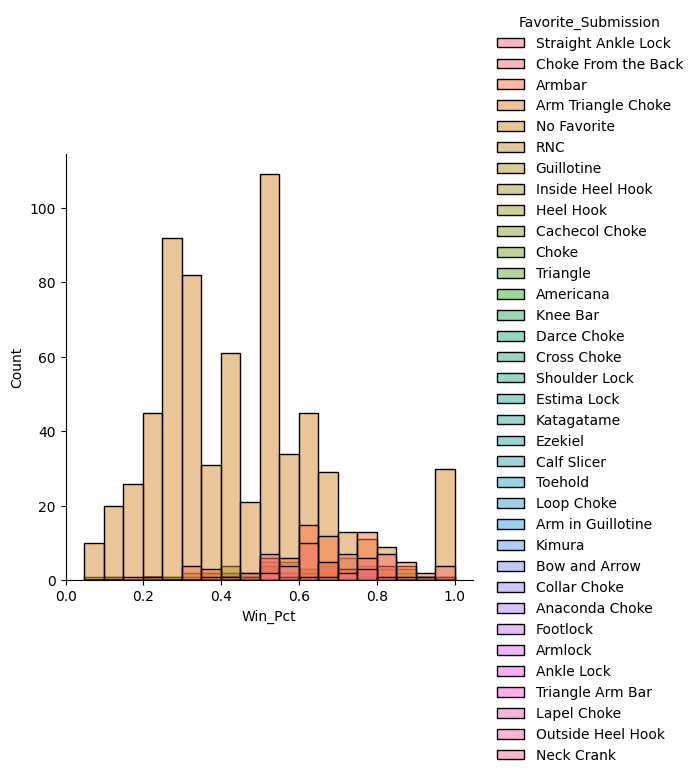

In [497]:
sns.displot(Athlete_Info, x='Win_Pct',binwidth = 0.05, hue='Favorite_Submission')
plt.show()

In [469]:
#Athlete_Info.groupby(['Favorite_Submission'])['Win_Pct'].mean().reset_index().sort_values(by=['Win_Pct'],ascending=False)
Athlete_Info.groupby(['Favorite_Submission'])['Win_Pct'].mean().reset_index().sort_values(by=['Win_Pct'],ascending=False)

,Favorite_Submission,Win_Pct
1,Anaconda Choke,0.833333
24,Lapel Choke,0.750000
13,Cross Choke,0.745496
2,Ankle Lock,0.711864
0,Americana,0.706710
14,Darce Choke,0.699637
11,Choke From the Back,0.680332
29,RNC,0.678189
16,Ezekiel,0.664580
8,Cachecol Choke,0.656250


hmmmmmm...

I am saddended that my personal favorite submission has the lowest win percentage.

In [478]:
Athlete_Info.groupby(['Favorite_Submission'])['Count'].sum().reset_index().sort_values(by=['Count'],ascending=False)

,Favorite_Submission,Count
27,No Favorite,673
5,Armbar,75
11,Choke From the Back,53
29,RNC,30
10,Choke,27
31,Straight Ankle Lock,16
23,Knee Bar,16
19,Heel Hook,16
33,Triangle,15
20,Inside Heel Hook,13


Though this shows that only 1 athlete has that as their favorite submission, so this should likely be taken with a grain of salt.

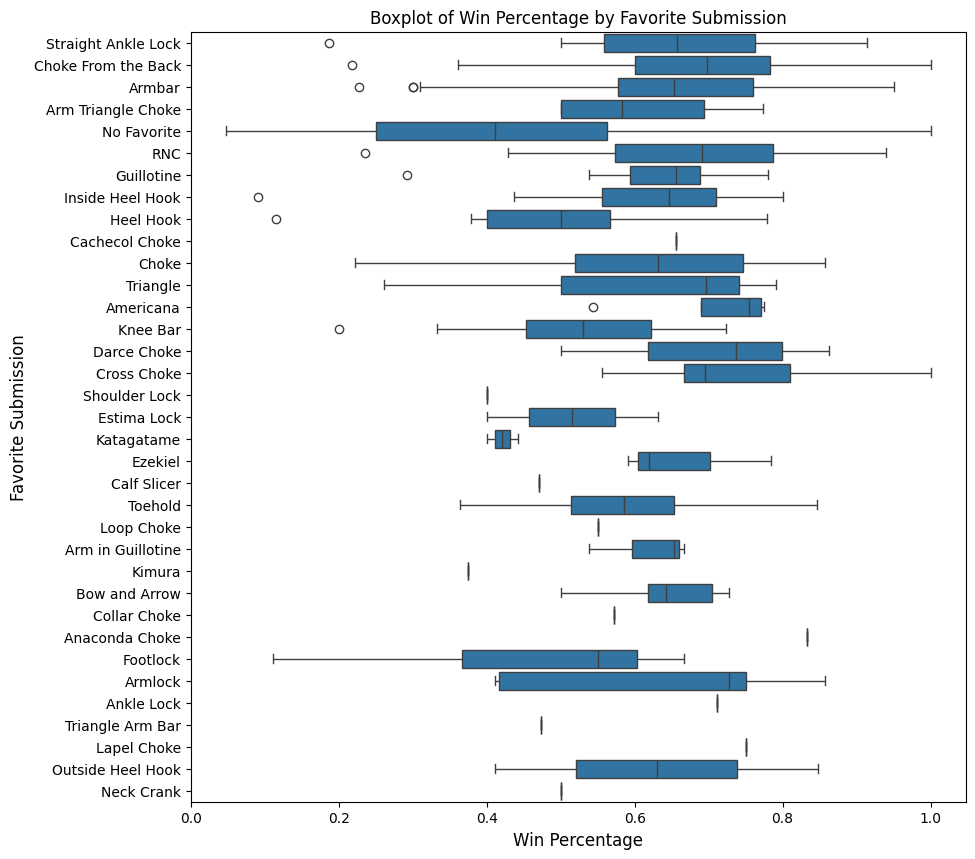

In [518]:
fig, ax = plt.subplots(figsize = (10,10))
sns.boxplot(data=Athlete_Info,x='Win_Pct',y='Favorite_Submission', ax=ax)
plt.title('Boxplot of Win Percentage by Favorite Submission')
plt.ylabel('Favorite Submission',size=12)
plt.xlabel('Win Percentage',size = 12)
plt.show()

## Kruskal Wallis Test

Since the data isn't normally distributed I will use the Kruskal Wallis Test, which will compare the medians.

The kruskal function in scipy stats will work for this, but I need to make an array for each favorite submission of their win percentages.

In [529]:
# This piece gives the locations of each of the groups
# Athlete_Info.groupby(['Favorite_Submission']).groups

# Now get the values at each location
sub_arrays = [Athlete_Info.loc[ids, 'Win_Pct'].values for ids in Athlete_Info.groupby(['Favorite_Submission']).groups.values()]

# Now kruskal

stats.kruskal(*sub_arrays) # Note the * is used to pass each of the arrays as separate arguments

KruskalResult(statistic=239.64260742794835, pvalue=9.116145215449475e-33)

P value is very small, so there is some statistical difference between at least two of the groups.

## Posthocs
Let's move on to posthoc tests. In this case I'll use Conover's test.

In [559]:
pc = sp.posthoc_conover(Athlete_Info, val_col = 'Win_Pct', group_col = 'Favorite_Submission',sort=True)
pd.set_option('display.max_columns',35)
pc

,Americana,Anaconda Choke,Ankle Lock,Arm Triangle Choke,Arm in Guillotine,Armbar,Armlock,Bow and Arrow,Cachecol Choke,Calf Slicer,...,Loop Choke,Neck Crank,No Favorite,Outside Heel Hook,RNC,Shoulder Lock,Straight Ankle Lock,Toehold,Triangle,Triangle Arm Bar
Americana,1.000000,0.661086,0.923530,0.429821,0.577276,4.865894e-01,0.467122,0.606902,0.843022,0.184570,...,0.456600,0.281016,1.897805e-03,0.493097,6.695934e-01,0.110449,0.504576,0.277459,0.360259,0.186866
Anaconda Choke,0.661086,1.000000,0.786604,0.348436,0.427732,4.000605e-01,0.372043,0.445791,0.614867,0.162916,...,0.349771,0.230648,4.057779e-02,0.376285,4.804532e-01,0.107778,0.402402,0.278350,0.330568,0.164569
Ankle Lock,0.923530,0.786604,1.000000,0.551618,0.644362,6.445829e-01,0.586933,0.679579,0.816196,0.260617,...,0.506409,0.353303,9.566292e-02,0.567132,7.421456e-01,0.180901,0.641196,0.470882,0.546881,0.262940
Arm Triangle Choke,0.429821,0.348436,0.551618,1.000000,0.862151,6.949006e-01,0.916321,0.750642,0.763137,0.407746,...,0.806335,0.562649,4.571218e-02,0.967496,5.338326e-01,0.272432,0.740333,0.875067,0.938510,0.411673
Arm in Guillotine,0.577276,0.427732,0.644362,0.862151,1.000000,9.071691e-01,0.932196,0.912152,0.859548,0.359471,...,0.724677,0.499455,4.991822e-02,0.854067,7.429504e-01,0.239040,0.933305,0.733375,0.887832,0.362992
Armbar,0.486589,0.400060,0.644583,0.694901,0.907169,1.000000e+00,0.777046,0.979426,0.892793,0.263045,...,0.636777,0.399330,4.597839e-22,0.741270,5.475714e-01,0.156041,0.953650,0.401894,0.576781,0.266333
Armlock,0.467122,0.372043,0.586933,0.916321,0.932196,7.770458e-01,1.000000,0.821486,0.807819,0.363226,...,0.753104,0.512359,1.693848e-02,0.899399,5.893977e-01,0.236266,0.822726,0.767423,0.958191,0.366962
Bow and Arrow,0.606902,0.445791,0.679579,0.750642,0.912152,9.794256e-01,0.821486,1.000000,0.910053,0.298613,...,0.656460,0.432226,6.843312e-03,0.766482,8.069846e-01,0.188682,0.956545,0.581250,0.742336,0.301905
Cachecol Choke,0.843022,0.614867,0.816196,0.763137,0.859548,8.927934e-01,0.807819,0.910053,1.000000,0.372032,...,0.665705,0.486506,1.807838e-01,0.761189,9.954973e-01,0.268809,0.883019,0.682343,0.776253,0.374967
Calf Slicer,0.184570,0.162916,0.260617,0.407746,0.359471,2.630448e-01,0.363226,0.298613,0.372032,1.000000,...,0.644971,0.843913,9.384572e-01,0.467253,2.164481e-01,0.831094,0.281247,0.430415,0.348157,0.995636


Lets look just at how everything compares to No Favorite

In [580]:

output_table = sp.sign_table(np.array(pc),upper=True,lower=True)
output_table.columns = pc.columns
output_table.index = pc.index
output_table['No Favorite'].reset_index()

,index,No Favorite
0,Americana,**
1,Anaconda Choke,*
2,Ankle Lock,NS
3,Arm Triangle Choke,*
4,Arm in Guillotine,*
5,Armbar,***
6,Armlock,*
7,Bow and Arrow,**
8,Cachecol Choke,NS
9,Calf Slicer,NS


Wow, theres a lot going on here, the majority of submissions are better than not having a favorite submission.

Lets make a heatmap to visualize this.

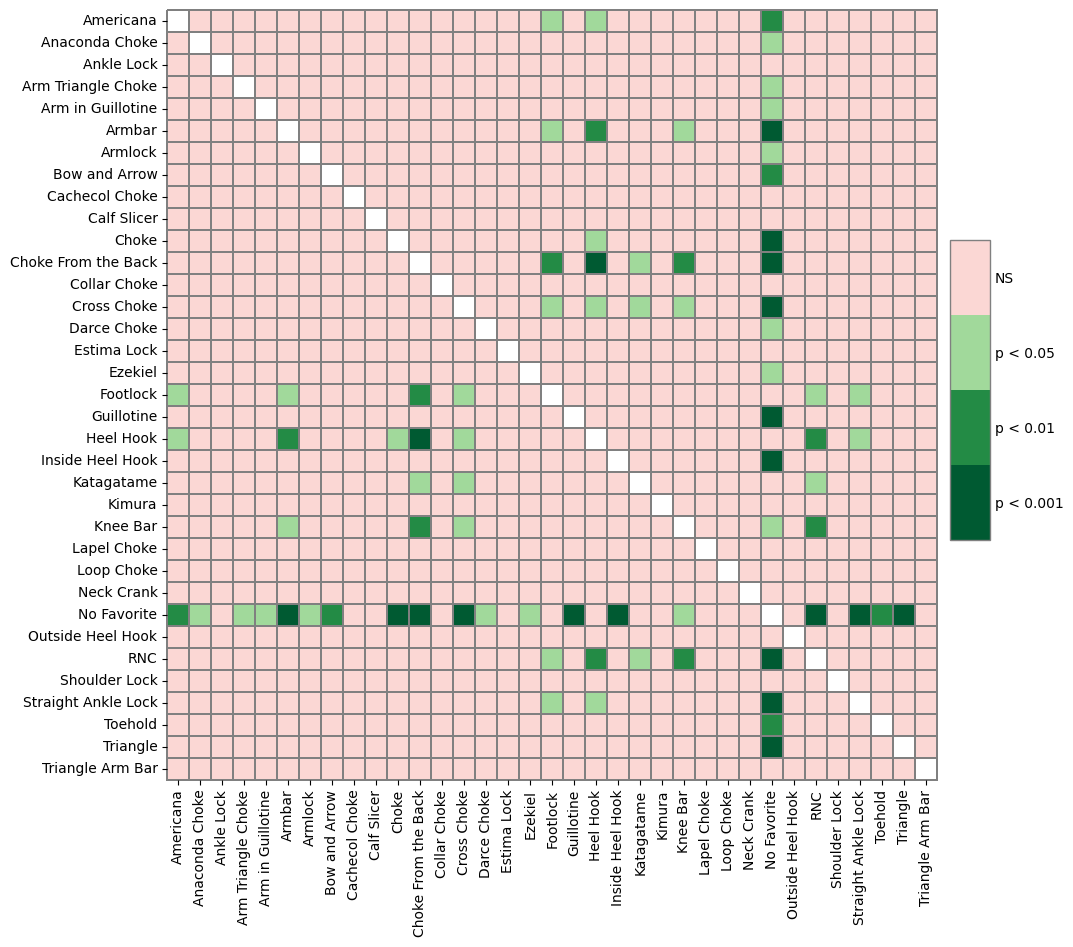

In [558]:
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.91, 0.35, 0.04, 0.3]}
fig, ax = plt.subplots(figsize = (10,10))
sp.sign_plot(pc, **heatmap_args, ax= ax)
#plt.legend(loc='upper right')
plt.show()

The benefit of doing all combinations is that there are some differences between other submissions, why are choke from the back and heel hook so different? Which one is larger?

In [586]:
Athlete_Info[(Athlete_Info['Favorite_Submission'] == 'Choke From the Back') | (Athlete_Info['Favorite_Submission'] == 'Heel Hook')].groupby(['Favorite_Submission'])['Win_Pct'].mean()

Favorite_Submission
Choke From the Back    0.680332
Heel Hook              0.492359
Name: Win_Pct, dtype: float64

Choke from the back is higher mean, what about median?

In [589]:
Athlete_Info[(Athlete_Info['Favorite_Submission'] == 'Choke From the Back') | (Athlete_Info['Favorite_Submission'] == 'Heel Hook')].groupby(['Favorite_Submission'])['Win_Pct'].median()

Favorite_Submission
Choke From the Back    0.698413
Heel Hook              0.500000
Name: Win_Pct, dtype: float64

Still pretty different. Keeping that ~20% difference. Lets graph.

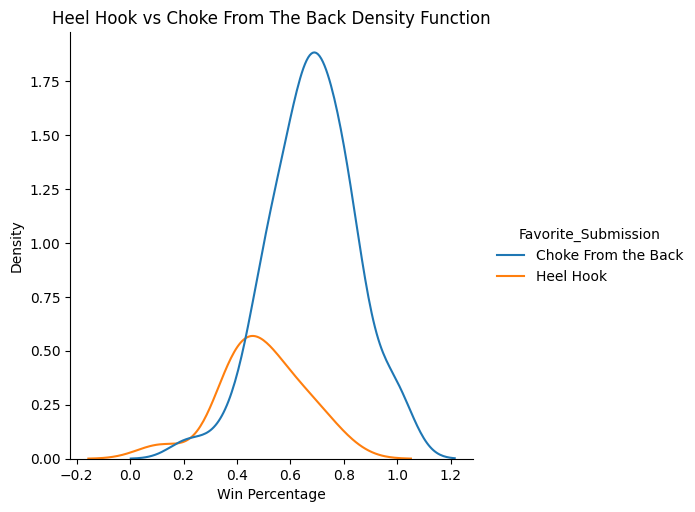

In [588]:
sns.displot(Athlete_Info[(Athlete_Info['Favorite_Submission'] == 'Choke From the Back') | (Athlete_Info['Favorite_Submission'] == 'Heel Hook')], x='Win_Pct', kind= 'kde', hue = 'Favorite_Submission',warn_singular=False)
plt.title('Heel Hook vs Choke From The Back Density Function',size=12)
plt.xlabel('Win Percentage')
plt.show()

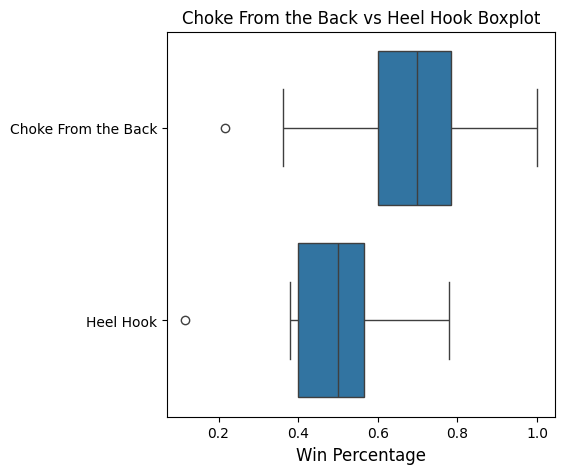

In [594]:
fig, ax = plt.subplots(figsize = (5,5))
sns.boxplot(data=Athlete_Info[(Athlete_Info['Favorite_Submission'] == 'Choke From the Back') | (Athlete_Info['Favorite_Submission'] == 'Heel Hook')],x='Win_Pct',y='Favorite_Submission', ax=ax)
plt.title('Choke From the Back vs Heel Hook Boxplot')
plt.ylabel('',size=12)
plt.xlabel('Win Percentage',size = 12)
plt.show()

Interesting findings. Now lets do a linear model with no favorite as reference

In [608]:

reg1 = smf.glm(formula='Win_Pct~C(Favorite_Submission, Treatment(reference = 27))',data=Athlete_Info).fit()
reg_summary1 = reg1.summary().tables[0]
reg_summary2 = reg1.summary().tables[1]


I want to make a nice looking table, so the intercept will be No Favorite and everything else is in order.

In [ ]:
# location is 27 for No Favorite
Submissions = pc.index.to_list()
Submissions.pop(27)


In [641]:
Submissions.insert(0,'No Favorite')

In [645]:
print(reg1.summary(xname=Submissions,title='Comparison of Favorite Submission on Win Percentage with No Favorite as Reference'))

Comparison of Favorite Submission on Win Percentage with No Favorite as Reference
Dep. Variable:                Win_Pct   No. Observations:                 1009
Model:                            GLM   Df Residuals:                      974
Model Family:                Gaussian   Df Model:                           34
Link Function:               Identity   Scale:                        0.038202
Method:                          IRLS   Log-Likelihood:                 233.22
Date:                Mon, 02 Oct 2023   Deviance:                       37.209
Time:                        13:31:28   Pearson chi2:                     37.2
No. Iterations:                     3   Pseudo R-squ. (CS):             0.2173
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
No Favorite             0.4392 

In [655]:

# Opening the existing HTML file
Func = open("Regression_Table.html","w")
Func.write(reg1.summary(xname=Submissions,title='Comparison of Favorite Submission on Win Percentage with No Favorite as Reference').as_html())
Func.close()

In [658]:
Submissions.pop(0)

'No Favorite'

In [660]:
Submissions.append('No Favorite')

In [669]:
from stargazer.stargazer import Stargazer
stargazer = Stargazer([reg1])
stargazer.title('Comparison of Favorite Submission on Win Percentage with No Favorite as Reference')
stargazer.show_model_numbers(False)
stargazer.significant_digits(2)
#stargazer.rename_covariates(Submissions)
og_names = stargazer.cov_names
new_names = Submissions
new_dict = dict(map(lambda i,j :(i,j), og_names,new_names))
stargazer.rename_covariates(new_dict)

Func = open("Regression_Table_Star.html","w")
Func.write(stargazer.render_html())
Func.close()

Overall this analysis has showed that having some favorite submissions are statistically better than not having a favorite submission, though this should be interpreted carefully. This sample is heavily imbalanced, for instance there is only one individual athlete who's favorite submission is the Anaconda Choke, but they have a win percentage near 80%, so the coefficient in our regression is very high. 

In terms of recommendations, from this analysis getting to the back is likely a good strategy as both Choke From the Back and Rear Naked Choke are statistically significant with a 20% difference in win percentage. Removing the submissions with only one athlete, I would also recommend the Armbar, Americana, and Straight Ankle Lock.